In [1]:
import simulate_data
import remove_data
import matrix_completion
import trunc_nnm
import errors

from sklearn.preprocessing import Normalizer
import numpy as np
import numpy.linalg as la
import pandas as pd

In [2]:
# simulate data
sim_df = simulate_data.sim_data(**simulate_data.sim_params)

# drop categorical feature for now
sim_df = sim_df.drop("Group", axis=1)

# normalize data
nrml = Normalizer()
sim_norm = nrml.fit_transform(sim_df)

pd.DataFrame(sim_norm).head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.000413,0.690638,0.000024,0.000012,0.000012,0.000000,0.000012,0.0,0.000000,0.031408,0.722518
1,0.000351,0.684316,0.000000,0.000015,0.000000,0.000015,0.000015,0.0,0.000000,0.043195,0.727905
2,0.000436,0.679155,0.000040,0.000000,0.000000,0.000020,0.000020,0.0,0.000000,0.052448,0.732118
3,0.001449,0.682136,0.000030,0.000030,0.000030,0.000000,0.000030,0.0,-0.002785,0.048679,0.729597
4,0.000419,0.678298,0.000027,0.000014,0.000000,0.000000,0.000014,0.0,0.035578,0.019322,0.733671


# Missing at Random

### How do error rates vary by rate of missingness?

In [3]:
results_lst = []
parameters = {"eps_outer": 1e-5,
                  "eps_inner": 1e-5,
                  "beta": 1,
                  "max_iter_outer": 1000,
                  "max_iter_inner": 1000}

for missingness_pct in np.arange(0, 1, .05):
    sim_obs = remove_data.missing_at_random(sim_norm, perc_remove=missingness_pct, rand_seed=23)
    
    sim_recovered_svt = matrix_completion.svt(sim_obs, tau=5)
    svt_error = la.norm(np.round(sim_norm, 4) - np.round(sim_recovered_svt, 4), ord='fro')
    
    sim_recovered_nnm = trunc_nnm.truncated_NNM(10, parameters, sim_obs)
    nnm_error = la.norm(np.round(sim_norm, 4) - np.round(sim_recovered_nnm, 4), ord='fro')
    
    results_lst.append([missingness_pct, svt_error, nnm_error])

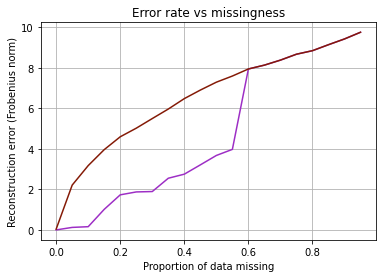

In [4]:
results_df = pd.DataFrame(results_lst, columns=["missingness", "SVT", "NNM"]).set_index("missingness")
errors.line_plot(results_df.index, results_df.SVT, results_df.NNM)

NNM seems to be pretty stable across parameters, but SVT results can change depending on $\tau$. SVT seems to converve with NNM results quite exactly when $\tau$ is really small or really large.

##### Here we hold the error rate at 40% and change $\tau$ for SVT

In [5]:
tau_lst = []

for tau in np.arange(0, 10, 1):
    sim_obs = remove_data.missing_at_random(sim_norm, perc_remove=0.4, rand_seed=23)
    
    sim_recovered_svt = matrix_completion.svt(sim_obs, tau=tau)
    svt_error = la.norm(np.round(sim_norm, 4) - np.round(sim_recovered_svt, 4), ord='fro')
    
    tau_lst.append([tau, svt_error])

<AxesSubplot:title={'center':'Error rate depending on tau'}, xlabel='tau'>

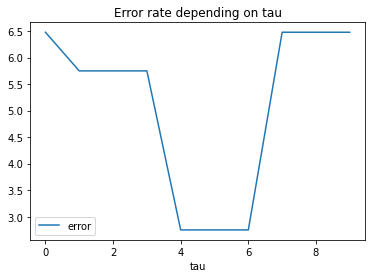

In [6]:
tau_df = pd.DataFrame(tau_lst, columns=["tau", "error"]).set_index("tau")
tau_df.plot(title="Error rate depending on tau")

SVT seems to want $\tau$ to be somewhere midway between 0 and the rank of the original matrix. Should test on other data.

### How do error rates vary by rank of the matrix?

### How do error rates vary by the type of missingness?

In [7]:
# assume 30% missingness for missing at random and conditional missingness

# or make dataframe with columns: random, slightly conditional, very conditional
# then the rows would be percent missingness

In [8]:
# create conditionally missing data
sim_conditional_missing = remove_data.missing_conditional_continuous(sim_df, "Income", "Age", 60)
# sim_conditional_missing = remove_data.missing_conditional_continuous(sim_df, "Continuous_HighLikelihood_0", "Income", 50000)
# sim_conditional_missing = remove_data.missing_conditional_continuous(sim_df, "Continuous_LowLikelihood_0", "Discrete_EvenLikelihood_0", 100)

In [10]:
sim_conditional_missing

,Age,Income,NChild,InCensus,Discrete_LowLikelihood_0,Discrete_EvenLikelihood_0,Discrete_HighLikelihood_0,Continuous_LowLikelihood_0,Continuous_EvenLikelihood_0,Continuous_HighLikelihood_0,PerfectClassifierOutcome
0,35,58586.712392,2,1,1,0,1,0.000000,0.000000,2664.352973,61291.065364
1,24,46830.098389,0,1,0,1,1,0.000000,0.000000,2955.978285,49813.076674
2,22,34291.053445,2,0,0,1,1,0.000000,0.000000,2648.160530,36965.213975
3,49,23068.236445,1,1,1,0,1,0.000000,-94.188018,1646.201934,24673.250360
4,31,NaN,2,1,0,0,1,0.000000,2631.579006,1429.152794,54267.366481
...,...,...,...,...,...,...,...,...,...,...,...
95,25,41026.627850,1,1,0,1,1,0.000000,2300.463965,-1226.490033,42129.601782
96,21,NaN,1,0,0,0,1,457.929739,2412.712740,2867.850262,59827.101060
97,85,66695.937093,1,1,0,1,1,0.000000,2684.512716,48.478754,69517.928563
98,61,49989.392880,0,0,0,1,1,0.000000,0.000000,2528.616255,52581.009135
